# OpenFoodFacts - Analysis of Nutrition Data

__Goal__: Investigate what kind of nutrition information is included in the product data.

<div class="alert alert-block alert-info">
  <b>This notebook focuses on the top 1,000 products in Open Food Facts.</b>
</div>

__To be analyzed:__
  - the Nutri-Score
  - the nutrition information, i.e. energy, fat, carbohydrates, sugar, salt.
  - the completeness and consistency of nutrition data.

__Summary (TL;TR)__
  - 



In [1]:
import pandas as pd
from urllib.request import urlopen, urlretrieve
from urllib.parse import urlencode
from pathlib import Path
import json
import math
from typing import Union

## Download Data from OpenFoodFacts API

___Only fetch the top 1,000 products with complete nutrition information!___

see also https://openfoodfacts.github.io/openfoodfacts-server/api/ref-v2/#cmp--schemas-product-nutrition

In [2]:
scope = "world"
API_URL = f"https://{scope}.openfoodfacts.org/api/v2/search?"

# no_nutrition_data, nutrition_data_per, nutrition_data_prepared_per, serving_size
# nutriscore_grade

PARAMS = {
    "page_size": 1000,
    "states_tags": "nutrition-facts-completed",
    "sort_by": "unique_scans_n",
    "fields": "code,brands,product_name,categories,no_nutrition_data,nutrition_data_per,nutrition_data_prepared_per,nutriscore_grade,nutriments,serving_size,compared_to_category,unique_scans_n,ecoscore_grade,nutriscore_data"
}

DATA_FILE = f"./off_{scope}_nutrition_top1000.json"

# skip download if data has been downloaded before
if not Path(DATA_FILE).exists():
    urlretrieve(API_URL + urlencode(PARAMS), DATA_FILE)

## Data Preparation

In [3]:
# load json file
with open(DATA_FILE) as f:
    data = json.load(f)

# create data frame from product information
prod_df = (pd.DataFrame(data['products'])
            .drop(['categories', 'compared_to_category'], axis=1)
            .set_index('code')
          )

def is_flag(value: Union[str, int]):
    try:
        return 1 == (int(value) if isinstance(value, str) and value != "" else value)
    except ValueError as e:
        print(f"cannot parse {value}", e)
        return False

# extract product type flags and energy values
flags = ["is_beverage", "is_cheese", "is_fat", "is_water"]
nrg_fields = ["energy_100g", "energy-kcal_100g", "energy_serving", "energy-kcal_serving"]

for flag in flags:
    prod_df[flag] = prod_df.nutriscore_data.map(lambda nutri: is_flag(nutri[flag]) if (isinstance(nutri, dict) and flag in nutri) else False)

for nrg in nrg_fields:
    prod_df[nrg] = prod_df.nutriments.map(lambda x: x[nrg] if nrg in x else None)

display(prod_df)

,brands,ecoscore_grade,no_nutrition_data,nutriments,nutriscore_data,nutriscore_grade,nutrition_data_per,nutrition_data_prepared_per,product_name,serving_size,unique_scans_n,is_beverage,is_cheese,is_fat,is_water,energy_100g,energy-kcal_100g,energy_serving,energy-kcal_serving
code,,,,,,,,,,,,,,,,,,,
3274080005003,Cristaline,not-applicable,,"{'bicarbonate': 0.219, 'bicarbonate_100g': 0.0...","{'energy': 0, 'energy_points': 0, 'energy_valu...",a,serving,100g,Eau de source,1 L,2109,True,False,False,True,0.0,0.0,0.0,0.0
7622210449283,"Lu,Mondelez",c,,"{'alcohol': 0, 'alcohol_100g': 0, 'alcohol_ser...","{'energy': 1962, 'energy_points': 5, 'energy_v...",d,100g,100g,Prince Chocolat biscuits au blé complet,20g,1592,False,False,False,False,1962.0,467.0,392.0,93.4
3017620425035,Ferrero,d,,"{'carbohydrates': 57.5, 'carbohydrates_100g': ...","{'energy': 2252, 'energy_points': 6, 'energy_v...",e,100g,100g,Nutella,15 g,1051,False,False,True,False,2252.0,539.0,338.0,80.8
3175680011480,Gerblé,c,,"{'carbohydrates': 64, 'carbohydrates_100g': 64...","{'energy': 1961, 'energy_points': 5, 'energy_v...",b,100g,100g,Biscuit Sésame,11.5g,842,False,False,False,False,1961.0,467.0,226.0,53.7
5449000214911,Coca cola,not-applicable,,"{'carbohydrates': 10.6, 'carbohydrates_100g': ...","{'energy': 180, 'energy_points': 6, 'energy_va...",e,100g,100g,Coca-cola,330ml,830,True,False,False,False,180.0,42.0,594.0,139.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5410081201039,"Côte d'Or,Fraft Foods",e,,"{'carbohydrates': 56, 'carbohydrates_100g': 56...","{'energy': 2209, 'energy_points': 6, 'energy_v...",e,100g,100g,L'Original noir,25 g,132,False,False,False,False,2209.0,528.0,552.0,132.0
5411188115496,Alpro,a,,"{'calcium': 0.12, 'calcium_100g': 0.12, 'calci...","{'energy': 138, 'energy_points': 0, 'energy_va...",a,100g,100g,Sojadrink ohne Zucker,100 ml,132,False,False,False,False,138.0,33.0,138.0,33.0
5449000214843,Coca-Cola,not-applicable,,"{'carbohydrates': 10.7, 'carbohydrates_100g': ...","{'energy': 182, 'energy_points': 7, 'energy_va...",e,100g,100g,Coca-Cola Cherry,330ml,132,True,False,False,False,182.0,43.0,601.0,142.0


## Exploratory Data Analysis

### Nutrition Data, Nutri-Score (and Eco-Score)

__Insights:__

- `no_nutrition_data` has bogus value that do not correlate to nutrition data
- Nutri-Score (`nutriscore_grade`) and Eco-Score (`ecoscore_grade`) has special values
  - `unknown`- missing data to compute nutri-score
  - `not-applicable` - some product categories have no nutri score: baby food, additives, salt, ...

In [4]:
prod_df.no_nutrition_data.value_counts()

no_nutrition_data
         936
null      41
on         7
false      4
off        4
true       1
Name: count, dtype: int64

In [5]:
prod_df.nutriscore_data.notna().value_counts(dropna=False)#.plot.barh(figsize=(5,2), title="Product has Nutri-Score");

nutriscore_data
True     982
False     18
Name: count, dtype: int64

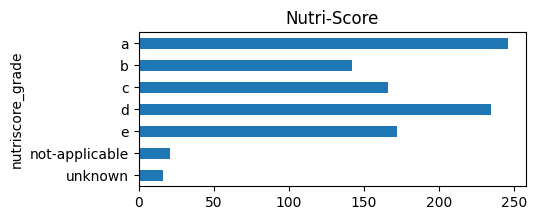

In [6]:
prod_df.nutriscore_grade.value_counts().sort_index(ascending=False).plot.barh(figsize=(5,2), title="Nutri-Score");

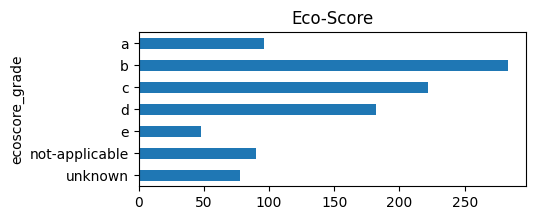

In [7]:
prod_df.ecoscore_grade.value_counts().sort_index(ascending=False).plot.barh(figsize=(5,2), title="Eco-Score");

## Cheese, Beverage, Water, Fat

In [8]:
for t in flags:
    display(prod_df[t].notna().value_counts())
    print()

is_beverage
True    1000
Name: count, dtype: int64

is_cheese
True    1000
Name: count, dtype: int64

is_fat
True    1000
Name: count, dtype: int64

is_water
True    1000
Name: count, dtype: int64

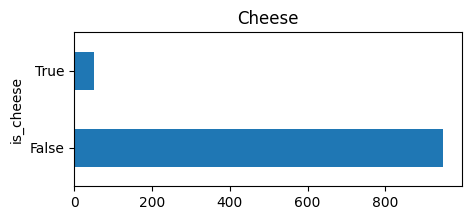

In [9]:
prod_df.is_cheese.value_counts().plot.barh(figsize=(5,2), title="Cheese");

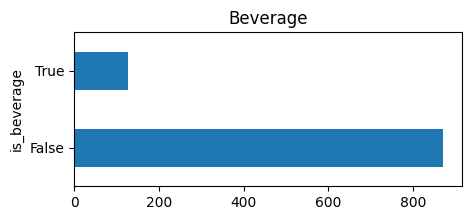

In [10]:
prod_df.is_beverage.value_counts().plot.barh(figsize=(5,2), title="Beverage");

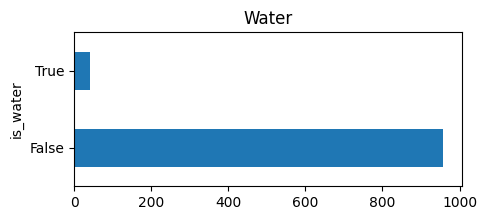

In [11]:
prod_df.is_water.value_counts().plot.barh(figsize=(5,2), title="Water");

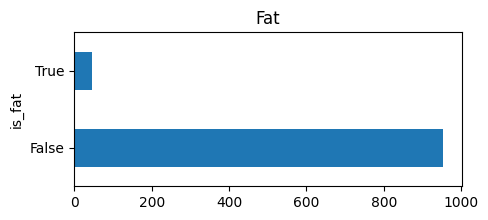

In [12]:
prod_df.is_fat.value_counts().plot.barh(figsize=(5,2), title="Fat");

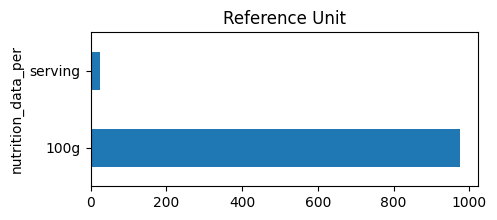

In [13]:
prod_df.nutrition_data_per.value_counts(dropna=False).plot.barh(figsize=(5,2), title="Reference Unit");

## Energy

- per 100g/ml
  - `energy_kcal_100g`
  - `energy_100g` (kJ, default unit)
- per serving
  - `energy_kcal_serving`
  - `energy_serving` (kJ, default unit)

In [14]:
for nrg in nrg_fields:
    display(prod_df[nrg].notna().value_counts())
    print()

energy_100g
True     974
False     26
Name: count, dtype: int64

energy-kcal_100g
True     969
False     31
Name: count, dtype: int64

energy_serving
True     699
False    301
Name: count, dtype: int64

energy-kcal_serving
True     694
False    306
Name: count, dtype: int64

In [15]:
prod_df["energy-kcal_100g"].map(lambda x: type(x)).value_counts()

energy-kcal_100g
<class 'float'>    1000
Name: count, dtype: int64

### Products without Energy kcal but with kJ

In [16]:
prod_df[lambda x: x['energy_100g'].notna() & ~x['energy-kcal_100g'].notna()]

,brands,ecoscore_grade,no_nutrition_data,nutriments,nutriscore_data,nutriscore_grade,nutrition_data_per,nutrition_data_prepared_per,product_name,serving_size,unique_scans_n,is_beverage,is_cheese,is_fat,is_water,energy_100g,energy-kcal_100g,energy_serving,energy-kcal_serving
code,,,,,,,,,,,,,,,,,,,
50457250,Heinz,b,,"{'carbohydrates': 23, 'carbohydrates_100g': 23...","{'energy': 435, 'energy_points': 1, 'energy_va...",d,100g,100g,Tomato Ketchup,15 g,216,False,False,False,False,435.0,NaN,65.2,NaN
5000328508153,Walkers,NaN,NaN,"{'carbohydrates': 51.5, 'carbohydrates_100g': ...",NaN,NaN,100g,NaN,Ready salted crisps,,170,False,False,False,False,2194.0,NaN,0.0,NaN
3302740025136,Fleury Michon,d,,"{'carbohydrates': 0.7, 'carbohydrates_100g': 0...","{'energy': 490, 'energy_points': 1, 'energy_va...",c,100g,100g,ZERO NITRITE - LE SUPERIEUR,30 g,164,False,False,False,False,490.0,NaN,147.0,NaN
5000127142190,"Kellogg, Kellogg's",d,,"{'alcohol': 0, 'alcohol_100g': 0, 'alcohol_ser...","{'energy': 1400, 'energy_points': 4, 'energy_v...",c,100g,100g,All-Bran,40g,154,False,False,False,False,1400.0,NaN,560.0,NaN
3095757697105,Fleury Michon,e,,"{'carbohydrates': 0.5, 'carbohydrates_100g': 0...","{'energy': 443, 'energy_points': 1, 'energy_va...",b,100g,100g,Blanc de Poulet - 25% de Sel*,40g,133,False,False,False,False,443.0,NaN,177.0,NaN


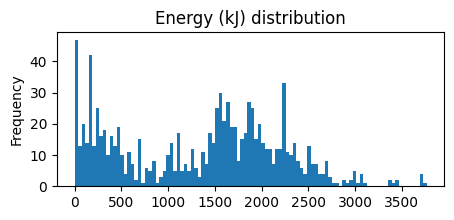

In [17]:
prod_df.energy_100g.plot.hist(bins=100, figsize=(5,2), title="Energy (kJ) distribution");

In [18]:
prod_df[lambda x: x['energy_100g'] <= 1.0]

,brands,ecoscore_grade,no_nutrition_data,nutriments,nutriscore_data,nutriscore_grade,nutrition_data_per,nutrition_data_prepared_per,product_name,serving_size,unique_scans_n,is_beverage,is_cheese,is_fat,is_water,energy_100g,energy-kcal_100g,energy_serving,energy-kcal_serving
code,,,,,,,,,,,,,,,,,,,
3274080005003,Cristaline,not-applicable,,"{'bicarbonate': 0.219, 'bicarbonate_100g': 0.0...","{'energy': 0, 'energy_points': 0, 'energy_valu...",a,serving,100g,Eau de source,1 L,2109,True,False,False,True,0.0000,0.0000,0.000,0.000
3268840001008,Cristaline,not-applicable,,"{'bicarbonate': 0.29, 'bicarbonate_100g': 0.02...","{'energy': 0, 'energy_points': 0, 'energy_valu...",a,serving,100g,Eau de source,1 L,791,True,False,False,True,0.0000,0.0000,0.000,0.000
8002270014901,San Pellegrino,not-applicable,,"{'bicarbonate': 0.244, 'bicarbonate_100g': 0.2...","{'energy': 0.0001, 'energy_points': 0, 'energy...",a,100g,serving,S. Pellegrino Water,1 L,648,True,False,False,True,0.0001,0.0000,0.001,0.000
3068320123264,"La Salvetat,Danone",not-applicable,,"{'bicarbonate': 0.53, 'bicarbonate_100g': 0.05...","{'energy': 0, 'energy_points': 0, 'energy_valu...",a,serving,100g,La salvetat,1 L,599,True,False,False,True,0.0000,0.0000,0.000,0.000
5449000131805,Coca-Cola,not-applicable,,"{'carbohydrates': 0, 'carbohydrates_100g': 0, ...","{'energy': 0.9, 'energy_points': 1, 'energy_va...",b,100g,100g,Coca-Cola zero azúcar,330 ml,523,True,False,False,False,0.9000,0.2000,2.970,0.660
7613035974685,Hépar,not-applicable,,"{'alcohol': 0, 'alcohol_100g': 0, 'alcohol_ser...","{'energy': 0.0001, 'energy_points': 0, 'energy...",a,100g,100g,hepar,1L,427,True,False,False,True,0.0001,0.0001,0.001,0.001
5449000131836,COCA-COLA,not-applicable,,"{'carbohydrates': 0, 'carbohydrates_100g': 0, ...","{'energy': 0.92, 'energy_points': 1, 'energy_v...",b,serving,100g,Coca-Cola zero,250 ml,416,True,False,False,False,0.9200,0.4000,2.300,1.000
3068320114453,Badoit,not-applicable,,"{'bicarbonate': 0.125, 'bicarbonate_100g': 0.1...","{'energy': 0, 'energy_points': 0, 'energy_valu...",a,100g,100g,Eau minérale naturelle finement pétillante,NaN,382,True,False,False,True,0.0000,0.0000,NaN,NaN
3257971309114,Mont Roucous,not-applicable,,"{'calcium': 0.00029, 'calcium_100g': 0.00029, ...","{'energy': 0, 'energy_points': 0, 'energy_valu...",a,100g,100g,Eau minérale naturelle,100ml,313,True,False,False,True,0.0000,0.0000,0.000,0.000


In [19]:
kcal_notna_df = prod_df[prod_df["energy-kcal_100g"].notna()]
kcal_factor = kcal_notna_df["energy_100g"] / kcal_notna_df["energy-kcal_100g"]
display(kcal_factor.isna().value_counts())
print()
#prod_df.loc[kcal_factor.isna().index]
display(kcal_factor[lambda x: (x <= 4.0) | (x >= 5.0)].value_counts().sort_index())
display(prod_df.loc[kcal_factor[lambda x: (x <= 4.0) | (x >= 5.0)].index])

False    939
True      30
Name: count, dtype: int64

0.000000     1
1.000000     3
2.300000     1
2.555556     1
3.500000     1
3.981481     1
3.984000     1
4.000000     3
5.000000     1
5.166667     1
9.291553     1
18.666667    1
inf          1
Name: count, dtype: int64

,brands,ecoscore_grade,no_nutrition_data,nutriments,nutriscore_data,nutriscore_grade,nutrition_data_per,nutrition_data_prepared_per,product_name,serving_size,unique_scans_n,is_beverage,is_cheese,is_fat,is_water,energy_100g,energy-kcal_100g,energy_serving,energy-kcal_serving
code,,,,,,,,,,,,,,,,,,,
8002270014901,San Pellegrino,not-applicable,,"{'bicarbonate': 0.244, 'bicarbonate_100g': 0.2...","{'energy': 0.0001, 'energy_points': 0, 'energy...",a,100g,serving,S. Pellegrino Water,1 L,648,True,False,False,True,0.0001,0.0000,0.001,0.000
7613035974685,Hépar,not-applicable,,"{'alcohol': 0, 'alcohol_100g': 0, 'alcohol_ser...","{'energy': 0.0001, 'energy_points': 0, 'energy...",a,100g,100g,hepar,1L,427,True,False,False,True,0.0001,0.0001,0.001,0.001
5449000131836,COCA-COLA,not-applicable,,"{'carbohydrates': 0, 'carbohydrates_100g': 0, ...","{'energy': 0.92, 'energy_points': 1, 'energy_v...",b,serving,100g,Coca-Cola zero,250 ml,416,True,False,False,False,0.9200,0.4000,2.300,1.000
3329757002998,Pure Via,b,,"{'alcohol': 0, 'alcohol_100g': 0, 'alcohol_ser...",{'nutriscore_not_applicable_for_category': 'en...,not-applicable,100g,100g,Poudre stevia,"2,5 g",322,False,False,False,False,7.0000,2.0000,0.175,0.050
7613035866386,"hepar,Contrex",not-applicable,,"{'bicarbonate': 0.372, 'bicarbonate_100g': 0.3...","{'energy': 0.0001, 'energy_points': 0, 'energy...",a,100g,100g,CONTREX eau minérale naturelle,NaN,312,True,False,False,True,0.0001,0.0001,NaN,NaN
3168930170549,Lipton,b,,"{'carbohydrates': 3.1, 'carbohydrates_100g': 3...","{'energy': 56, 'energy_points': 2, 'energy_val...",c,100g,100g,Ice tea,250 ml,241,True,False,False,False,56.0000,3.0000,140.000,7.500
3502110009357,"PepsiCo, Pepsi zero",not-applicable,,"{'carbohydrates': 0, 'carbohydrates_100g': 0, ...","{'energy': 2, 'energy_points': 1, 'energy_valu...",b,100g,100g,Pepsi Max,250 ml,227,True,False,False,False,2.0000,0.4000,5.000,1.000
20656935,Saguaro,not-applicable,,"{'carbohydrates': 0, 'carbohydrates_100g': 0, ...","{'energy': 4, 'energy_points': 1, 'energy_valu...",b,100g,100g,Pétillante saveur Citron.,200 ml,223,True,False,False,False,4.0000,1.0000,8.000,2.000
3179730115821,Contrex,not-applicable,,"{'bicarbonate': 0.0372, 'bicarbonate_100g': 0....","{'energy': 0.0001, 'energy_points': 0, 'energy...",a,100g,serving,CONTREX eau minerale naturelle 1L,1000 ml,190,True,False,False,True,0.0001,0.0001,0.001,0.001


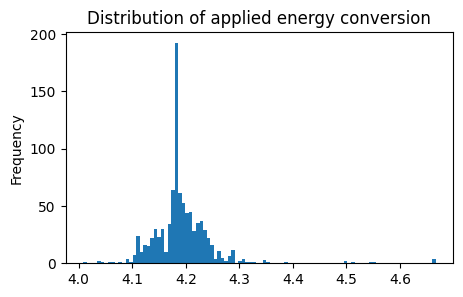

In [20]:
kcal_factor[lambda x: (x > 4.0) & (x < 5.0)].plot.hist(bins=100, figsize=(5,3), title="Distribution of applied energy conversion");

## Top nutrition keys

In [21]:
keys = [k for nutri in prod_df.nutriments for k in nutri.keys()]
key_counts = pd.Series(keys).value_counts()
key_counts

fruits-vegetables-nuts-estimate-from-ingredients_100g       992
fruits-vegetables-nuts-estimate-from-ingredients_serving    992
salt_unit                                                   989
salt_value                                                  988
salt                                                        988
                                                           ... 
silica_prepared                                               1
silica_prepared_serving                                       1
silica_prepared_unit                                          1
sulfates_prepared                                             1
de-strontium_value                                            1
Name: count, Length: 795, dtype: int64

### Units used for nutrition values

In [22]:
units = [key for key in key_counts.index if "unit" in key]
key_counts.loc[units].head(20)

salt_unit               989
sodium_unit             988
energy_unit             976
carbohydrates_unit      975
fat_unit                975
proteins_unit           974
saturated-fat_unit      974
energy-kcal_unit        972
sugars_unit             972
energy-kj_unit          788
fiber_unit              735
calcium_unit            137
magnesium_unit           97
alcohol_unit             85
iron_unit                61
vitamin-b1_unit          61
sodium_prepared_unit     57
salt_prepared_unit       57
energy_prepared_unit     57
cocoa_unit               56
Name: count, dtype: int64

In [23]:
top_units = list(key_counts.loc[units].head(11).index)
top_units

['salt_unit',
 'sodium_unit',
 'energy_unit',
 'carbohydrates_unit',
 'fat_unit',
 'proteins_unit',
 'saturated-fat_unit',
 'energy-kcal_unit',
 'sugars_unit',
 'energy-kj_unit',
 'fiber_unit']

In [24]:
res = [f"{v} - {k}" for nutri in prod_df.nutriments for k,v in nutri.items() if k in top_units]
pd.Series(res).value_counts()

g - carbohydrates_unit     972
kcal - energy-kcal_unit    972
g - fat_unit               972
g - saturated-fat_unit     971
g - proteins_unit          970
g - sugars_unit            969
g - sodium_unit            955
g - salt_unit              954
kJ - energy-kj_unit        769
kJ - energy_unit           768
g - fiber_unit             733
kcal - energy_unit         189
mg - salt_unit              33
mg - sodium_unit            33
kj - energy-kj_unit         19
kj - energy_unit            19
 - saturated-fat_unit        3
 - carbohydrates_unit        3
 - fat_unit                  3
 - proteins_unit             3
 - sugars_unit               3
 - salt_unit                 2
µg - proteins_unit           1
mg - fiber_unit              1
 - fiber_unit                1
Name: count, dtype: int64

### Energy

In [25]:
energy = [key for key in key_counts.index if "energy" in key]
key_counts.loc[energy].head(20)

energy_value                  976
energy                        976
energy_unit                   976
energy_100g                   974
energy-kcal_unit              972
energy-kcal_value             971
energy-kcal                   971
energy-kcal_100g              969
energy-kcal_value_computed    968
energy-kj_unit                788
energy-kj_value               786
energy-kj_100g                786
energy-kj                     786
energy-kj_value_computed      783
energy_serving                699
energy-kcal_serving           694
energy-kj_serving             607
energy_prepared_unit           57
energy-kj_prepared_unit        56
energy-kcal_prepared_unit      54
Name: count, dtype: int64

In [26]:
energies = prod_df.nutriments.map(lambda obj: [f"{k}: {v}" for k,v in obj.items() if "energy" in k])
energies

code
3274080005003    [energy: 0, energy-kcal: 0, energy-kcal_100g: ...
7622210449283    [energy: 1962, energy-kcal: 467, energy-kcal_1...
3017620425035    [energy: 2252, energy-kcal: 539, energy-kcal_1...
3175680011480    [energy: 1961, energy-kcal: 467, energy-kcal_1...
5449000214911    [energy: 180, energy-kcal: 42, energy-kcal_100...
                                       ...                        
5410081201039    [energy: 2209, energy-kcal: 528, energy-kcal_1...
5411188115496    [energy: 138, energy-kcal: 33, energy-kcal_100...
5449000214843    [energy: 182, energy-kcal: 43, energy-kcal_100...
6111128000071    [energy: 0, energy-kcal: 0, energy-kcal_100g: ...
8410076481597    [energy: 2057, energy-kcal: 492, energy-kcal_1...
Name: nutriments, Length: 1000, dtype: object

In [27]:
energies.iloc[0]

['energy: 0',
 'energy-kcal: 0',
 'energy-kcal_100g: 0',
 'energy-kcal_serving: 0',
 'energy-kcal_unit: kcal',
 'energy-kcal_value: 0',
 'energy-kcal_value_computed: 0',
 'energy-kj: 0',
 'energy-kj_100g: 0',
 'energy-kj_serving: 0',
 'energy-kj_unit: kJ',
 'energy-kj_value: 0',
 'energy-kj_value_computed: 0',
 'energy_100g: 0',
 'energy_serving: 0',
 'energy_unit: kJ',
 'energy_value: 0']

In [28]:
#energies.loc["5410041143508"]

In [29]:
#energies.loc["3330720244017"]

## Process Energy Information

In [30]:
prod_df["kcal_100"] = prod_df.nutriments.map(lambda obj: obj.get("energy-kcal_100g"))
prod_df["kj_100"] = prod_df.nutriments.map(lambda obj: obj.get("energy-kj_100g"))
prod_df["nrg_100"] = prod_df.nutriments.map(lambda obj: obj.get("energy_100g"))
prod_df["nrg"] = prod_df.nutriments.map(lambda obj: obj.get("energy"))
prod_df

,brands,ecoscore_grade,no_nutrition_data,nutriments,nutriscore_data,nutriscore_grade,nutrition_data_per,nutrition_data_prepared_per,product_name,serving_size,...,is_fat,is_water,energy_100g,energy-kcal_100g,energy_serving,energy-kcal_serving,kcal_100,kj_100,nrg_100,nrg
code,,,,,,,,,,,,,,,,,,,,,
3274080005003,Cristaline,not-applicable,,"{'bicarbonate': 0.219, 'bicarbonate_100g': 0.0...","{'energy': 0, 'energy_points': 0, 'energy_valu...",a,serving,100g,Eau de source,1 L,...,False,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7622210449283,"Lu,Mondelez",c,,"{'alcohol': 0, 'alcohol_100g': 0, 'alcohol_ser...","{'energy': 1962, 'energy_points': 5, 'energy_v...",d,100g,100g,Prince Chocolat biscuits au blé complet,20g,...,False,False,1962.0,467.0,392.0,93.4,467.0,1962.0,1962.0,1962.0
3017620425035,Ferrero,d,,"{'carbohydrates': 57.5, 'carbohydrates_100g': ...","{'energy': 2252, 'energy_points': 6, 'energy_v...",e,100g,100g,Nutella,15 g,...,True,False,2252.0,539.0,338.0,80.8,539.0,2252.0,2252.0,2252.0
3175680011480,Gerblé,c,,"{'carbohydrates': 64, 'carbohydrates_100g': 64...","{'energy': 1961, 'energy_points': 5, 'energy_v...",b,100g,100g,Biscuit Sésame,11.5g,...,False,False,1961.0,467.0,226.0,53.7,467.0,1961.0,1961.0,1961.0
5449000214911,Coca cola,not-applicable,,"{'carbohydrates': 10.6, 'carbohydrates_100g': ...","{'energy': 180, 'energy_points': 6, 'energy_va...",e,100g,100g,Coca-cola,330ml,...,False,False,180.0,42.0,594.0,139.0,42.0,180.0,180.0,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5410081201039,"Côte d'Or,Fraft Foods",e,,"{'carbohydrates': 56, 'carbohydrates_100g': 56...","{'energy': 2209, 'energy_points': 6, 'energy_v...",e,100g,100g,L'Original noir,25 g,...,False,False,2209.0,528.0,552.0,132.0,528.0,NaN,2209.0,2209.0
5411188115496,Alpro,a,,"{'calcium': 0.12, 'calcium_100g': 0.12, 'calci...","{'energy': 138, 'energy_points': 0, 'energy_va...",a,100g,100g,Sojadrink ohne Zucker,100 ml,...,False,False,138.0,33.0,138.0,33.0,33.0,138.0,138.0,138.0
5449000214843,Coca-Cola,not-applicable,,"{'carbohydrates': 10.7, 'carbohydrates_100g': ...","{'energy': 182, 'energy_points': 7, 'energy_va...",e,100g,100g,Coca-Cola Cherry,330ml,...,False,False,182.0,43.0,601.0,142.0,43.0,182.0,182.0,182.0


In [31]:
# kcal entered by user for 100g (or missing)
prod_df.kcal_100.notna().rename("energy-kcal_100g").value_counts()

energy-kcal_100g
True     969
False     31
Name: count, dtype: int64

In [32]:
# kJ entered by user for 100g (or missing)
prod_df.kj_100.notna().rename("energy-kj_100g").value_counts()

energy-kj_100g
True     786
False    214
Name: count, dtype: int64

In [33]:
# calculated kJ ???
prod_df.nrg_100.isna().rename("energy_100g").value_counts()

energy_100g
False    974
True      26
Name: count, dtype: int64

In [34]:
# old "energy" field -> better ignore
prod_df.nrg.isna().rename("energy").value_counts()

energy
False    976
True      24
Name: count, dtype: int64

In [35]:
# energy field is often the sam as energy_100g
(prod_df.nrg_100 == prod_df.nrg).value_counts()

True     964
False     36
Name: count, dtype: int64

In [36]:
#prod_df[prod_df.nrg_100 != prod_df.nrg]

In [37]:
# energy_100g equals energy-kj_100g except where energy-kj_100g is missing
(prod_df.nrg_100 == prod_df.kj_100).value_counts()

True     786
False    214
Name: count, dtype: int64

In [38]:
(prod_df.nrg_100 == prod_df.kcal_100).value_counts()
prod_df[prod_df.nrg_100 != prod_df.kj_100]
prod_df[prod_df.kcal_100.isna()]

,brands,ecoscore_grade,no_nutrition_data,nutriments,nutriscore_data,nutriscore_grade,nutrition_data_per,nutrition_data_prepared_per,product_name,serving_size,...,is_fat,is_water,energy_100g,energy-kcal_100g,energy_serving,energy-kcal_serving,kcal_100,kj_100,nrg_100,nrg
code,,,,,,,,,,,,,,,,,,,,,
3057640257773,Volvic,not-applicable,,"{'bicarbonate': 0.074, 'bicarbonate_100g': 0.0...","{'energy': None, 'energy_points': 0, 'energy_v...",a,serving,100g,Volvic,1l,...,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7613036249928,Vittel,not-applicable,,"{'calcium': 0.0024, 'calcium_100g': 0.0024, 'c...","{'energy': None, 'energy_points': 0, 'energy_v...",a,100g,100g,eau minerale,1 L,...,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5942219000059,Borsec,not-applicable,,"{'calcium': 0.344, 'calcium_100g': 0.0344, 'ca...",NaN,unknown,serving,100g,"Borsec, regina apelor minerale apă minerală, n...",1 l,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3068320120256,Evian,not-applicable,,"{'bicarbonate': 0.036, 'bicarbonate_100g': 0.0...","{'energy': None, 'energy_points': 0, 'energy_v...",a,100g,100g,Eau minérale naturelle,250ml,...,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3254380008430,Cristaline,not-applicable,,"{'bicarbonate': 0.264, 'bicarbonate_label': 'B...","{'energy': None, 'energy_points': 0, 'energy_v...",a,serving,serving,Eau de source gazéifiée,NaN,...,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3504182920011,Azura,not-applicable,on,{'fruits-vegetables-legumes-estimate-from-ingr...,"{'energy': 142, 'energy_points': 0, 'energy_va...",a,100g,100g,Tomates Gourmet,1 portion (250 g),...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5942219111113,Romaqua Group,not-applicable,null,{'fruits-vegetables-nuts-estimate-from-ingredi...,"{'energy': None, 'energy_points': 0, 'energy_v...",a,serving,100g,,123456g,...,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3067140013120,LEROUX,a,,"{'carbohydrates_prepared': 2.8, 'carbohydrates...","{'energy': 1350, 'energy_points': 10, 'energy_...",c,100g,serving,Chicorée soluble nature,5 g,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3088545004001,Lune de Miel,b,on,{'fruits-vegetables-legumes-estimate-from-ingr...,"{'energy': 1390, 'energy_points': 4, 'energy_v...",d,100g,100g,Miel de Fleurs Liquide Doseur 500g,NaN,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
prod_df[prod_df.nrg_100.isna() & ~prod_df.is_water]

,brands,ecoscore_grade,no_nutrition_data,nutriments,nutriscore_data,nutriscore_grade,nutrition_data_per,nutrition_data_prepared_per,product_name,serving_size,...,is_fat,is_water,energy_100g,energy-kcal_100g,energy_serving,energy-kcal_serving,kcal_100,kj_100,nrg_100,nrg
code,,,,,,,,,,,,,,,,,,,,,
5942219000059,Borsec,not-applicable,,"{'calcium': 0.344, 'calcium_100g': 0.0344, 'ca...",NaN,unknown,serving,100g,"Borsec, regina apelor minerale apă minerală, n...",1 l,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3504182920011,Azura,not-applicable,on,{'fruits-vegetables-legumes-estimate-from-ingr...,"{'energy': 142, 'energy_points': 0, 'energy_va...",a,100g,100g,Tomates Gourmet,1 portion (250 g),...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3067140013120,LEROUX,a,,"{'carbohydrates_prepared': 2.8, 'carbohydrates...","{'energy': 1350, 'energy_points': 10, 'energy_...",c,100g,serving,Chicorée soluble nature,5 g,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3088545004001,Lune de Miel,b,on,{'fruits-vegetables-legumes-estimate-from-ingr...,"{'energy': 1390, 'energy_points': 4, 'energy_v...",d,100g,100g,Miel de Fleurs Liquide Doseur 500g,NaN,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3664346305990,Poulain,d,,"{'calcium_label': 'Calcium', 'calcium_prepared...","{'energy': 302, 'energy_points': 0, 'energy_va...",b,100g,100g,Grand Arôme 32% de Cacao,1 bol 100 ml,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3187570015447,Malongo,e,on,{'fruits-vegetables-legumes-estimate-from-ingr...,NaN,unknown,100g,100g,Café moulu pur arabica des petits producteurs,NaN,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7610313390076,bioforce france,a,,"{'carbohydrates': 2.5, 'carbohydrates_serving'...",{'nutriscore_not_applicable_for_category': 'en...,not-applicable,serving,100g,Sel aux herbes HERBAMARE 275g,NaN,...,False,False,NaN,NaN,75.0,18.0,NaN,NaN,NaN,75.0
5942325000233,,not-applicable,on,"{'nova-group': 1, 'nova-group_100g': 1, 'nova-...",NaN,NaN,100g,100g,Bucovina Apa Plata,NaN,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4056489361855,Maribel,a,,{'fruits-vegetables-legumes-estimate-from-ingr...,"{'energy': 1390, 'energy_points': 4, 'energy_v...",d,100g,100g,Miel crémeux français & responsable,NaN,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
prod_df.loc["20072803"].nutriments

{'fruits-vegetables-legumes-estimate-from-ingredients_100g': 0,
 'fruits-vegetables-legumes-estimate-from-ingredients_serving': 0,
 'fruits-vegetables-nuts-estimate-from-ingredients_100g': 0,
 'fruits-vegetables-nuts-estimate-from-ingredients_serving': 0}

## Calculate Energy

Example for single product
  - 3330720244017 - Konfiture - only serving but not 100g (wrong data input)
  - 5410081201039
  - 7622210449283 - Lu, Mondelez


In [41]:
prod = prod_df.loc["5410081201039"]
prod

brands                                                     Côte d'Or,Fraft Foods
ecoscore_grade                                                                 e
no_nutrition_data                                                               
nutriments                     {'carbohydrates': 56, 'carbohydrates_100g': 56...
nutriscore_data                {'energy': 2209, 'energy_points': 6, 'energy_v...
nutriscore_grade                                                               e
nutrition_data_per                                                          100g
nutrition_data_prepared_per                                                 100g
product_name                                                     L'Original noir
serving_size                                                                25 g
unique_scans_n                                                               132
is_beverage                                                                False
is_cheese                   

In [42]:
energy_kcal_100g = prod.nutriments.get("energy-kcal_100g")
energy_kj_100g = prod.nutriments.get("energy-kj_100g", prod.nutriments.get("energy_100g"))

serving_size = prod.nutriments.get("serving_size")
has_serving = isinstance(serving_size, str) and len(service_size) != 0

if (has_serving):
    energy_kcal_serving = prod.nutriments.get("energy-kcal_serving")
    energy_kj_serving = prod.nutriments.get("energy-kj_serving")

print(energy_kcal_100g)
print(energy_kj_100g)
print(has_serving)
print(energy_kcal_serving)
print(energy_kj_serving)

528
2209
False


NameError: name 'energy_kcal_serving' is not defined

In [ ]:
prod.nutriments.get("energy_100g")
prod.nutriments.get("energy")

In [ ]:
from collections import defaultdict

d = defaultdict
d

In [ ]:
{k:v for k,v in prod.nutriments.items() if "energy" in k}
#prod.nutriments

In [ ]:


prod = prod_df.loc["5000328508153"]
{k:v for k,v in prod.nutriments.items() if "energy" in k}
#prod.nutriments
#prod.get("serving_size")